# MATH60005/70005: Optimisation Coursework
## Part II: Dynamic Optimisation

**CID: 02210303**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

## Part II.a): Single System Dynamic Optimisation

### Problem Formulation

Given the dynamical system:
$$x_0 = \bar{x}, \quad x_i = ax_{i-1} + bu_i, \quad i = 1, \ldots, N$$

We can derive:
$$x_i = a^i\bar{x} + \sum_{n=1}^{i} a^{i-n}bu_n$$

This leads to the matrix formulation:
$$\mathbf{x} = S\mathbf{u} + \mathbf{b}$$

where:
$$S = \begin{pmatrix}
b & 0 & \cdots & 0 \\
ab & b & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
a^{N-1}b & a^{N-2}b & \cdots & b
\end{pmatrix}, \quad
\mathbf{b} = \begin{pmatrix}
-a\bar{x} \\
-a^2\bar{x} \\
\vdots \\
-a^N\bar{x}
\end{pmatrix}$$

The optimization problem becomes:
$$\min_{\mathbf{u} \in \mathbb{R}^N} \|S\mathbf{u} - \mathbf{b}\|_2^2 + \gamma\|\mathbf{u}\|_2^2$$

In [2]:
def construct_system_matrix(a, b, N):
    """
    Construct the system matrix S for the dynamical system.
    
    Parameters:
    -----------
    a : float
        System parameter a
    b : float
        System parameter b
    N : int
        Number of time steps
    
    Returns:
    --------
    S : ndarray of shape (N, N)
        Lower triangular system matrix
    """
    S = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1):
            S[i, j] = (a ** (i - j)) * b
    return S


def construct_b_vector(a, x_bar, N):
    """
    Construct the b vector for the dynamical system.
    
    Parameters:
    -----------
    a : float
        System parameter a
    x_bar : float
        Initial condition
    N : int
        Number of time steps
    
    Returns:
    --------
    b : ndarray of shape (N,)
        Right-hand side vector
    """
    b = np.array([-(a ** (i + 1)) * x_bar for i in range(N)])
    return b


def solve_regularized_least_squares(S, b, gamma):
    """
    Solve the regularized least squares problem:
    min ||Su - b||^2 + gamma ||u||^2
    
    Parameters:
    -----------
    S : ndarray of shape (N, N)
        System matrix
    b : ndarray of shape (N,)
        Right-hand side vector
    gamma : float
        Regularization parameter
    
    Returns:
    --------
    u_star : ndarray of shape (N,)
        Optimal control sequence
    """
    N = S.shape[0]
    # Solution: u* = (S^T S + gamma I)^{-1} S^T b
    A = S.T @ S + gamma * np.eye(N)
    rhs = S.T @ b
    u_star = solve(A, rhs)
    return u_star


def compute_trajectory(a, b, x_bar, u):
    """
    Compute the state trajectory given control sequence.
    
    Parameters:
    -----------
    a : float
        System parameter a
    b : float
        System parameter b
    x_bar : float
        Initial condition
    u : ndarray of shape (N,)
        Control sequence
    
    Returns:
    --------
    x : ndarray of shape (N+1,)
        State trajectory (including initial state)
    """
    N = len(u)
    x = np.zeros(N + 1)
    x[0] = x_bar
    
    for i in range(N):
        x[i + 1] = a * x[i] + b * u[i]
    
    return x

### Existence and Uniqueness

The objective function is:
$$f(\mathbf{u}) = \mathbf{u}^\top(S^\top S + \gamma I)\mathbf{u} - 2\mathbf{b}^\top S\mathbf{u} + \mathbf{b}^\top\mathbf{b}$$

Since $S^\top S + \gamma I \succ 0$ (positive definite for $\gamma > 0$), $f$ is strictly convex and has a unique global minimizer $\mathbf{u}^*$.

### Norm Bound

For any $\mathbf{u}_0$ minimizing the unregularized problem ($\gamma = 0$):
$$\|S\mathbf{u}_0 - \mathbf{b}\|_2^2 + \gamma\|\mathbf{u}^*\|_2^2 \leq \|S\mathbf{u}^* - \mathbf{b}\|_2^2 + \gamma\|\mathbf{u}^*\|_2^2 \leq \|S\mathbf{u}_0 - \mathbf{b}\|_2^2 + \gamma\|\mathbf{u}_0\|_2^2$$

This implies $\|\mathbf{u}^*\| \leq \|\mathbf{u}_0\|$.

In [3]:
# Parameters for Part II.a)
N = 50
a = 1.0
b = -0.01
x_bar = 1.0
gamma_values = [1e-3, 1e-2, 0.1, 1.0]

# Construct system matrices
S = construct_system_matrix(a, b, N)
b_vec = construct_b_vector(a, x_bar, N)

# Solve for different gamma values
results_IIa = {}
for gamma in gamma_values:
    u_star = solve_regularized_least_squares(S, b_vec, gamma)
    x_star = compute_trajectory(a, b, x_bar, u_star)
    results_IIa[gamma] = {'u': u_star, 'x': x_star}

print("Part II.a) - Results computed for gamma values:", gamma_values)

Part II.a) - Results computed for gamma values: [0.001, 0.01, 0.1, 1.0]


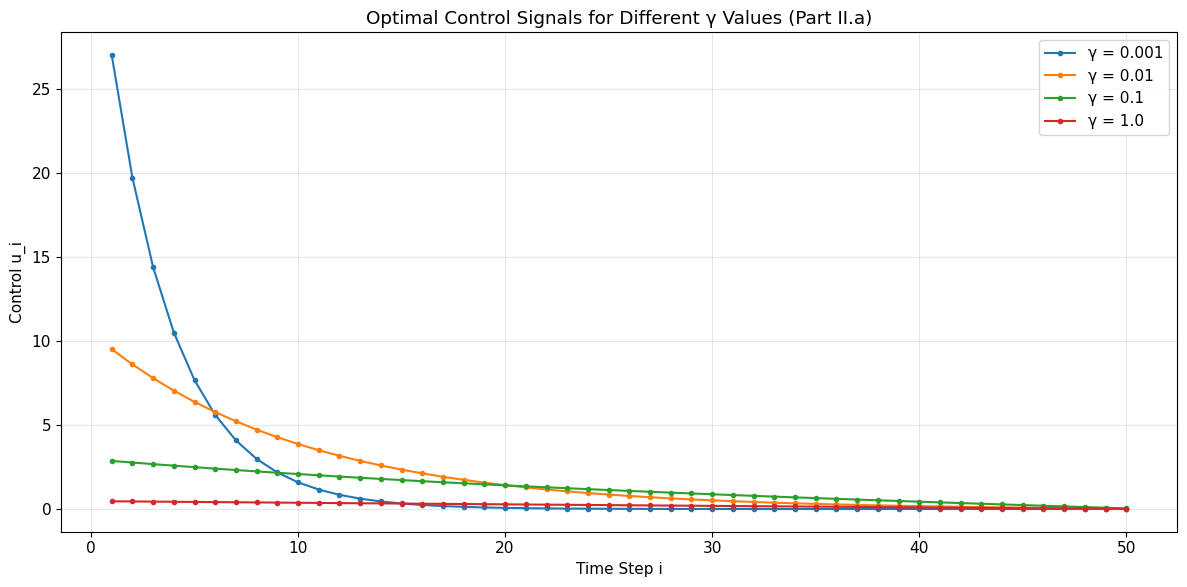

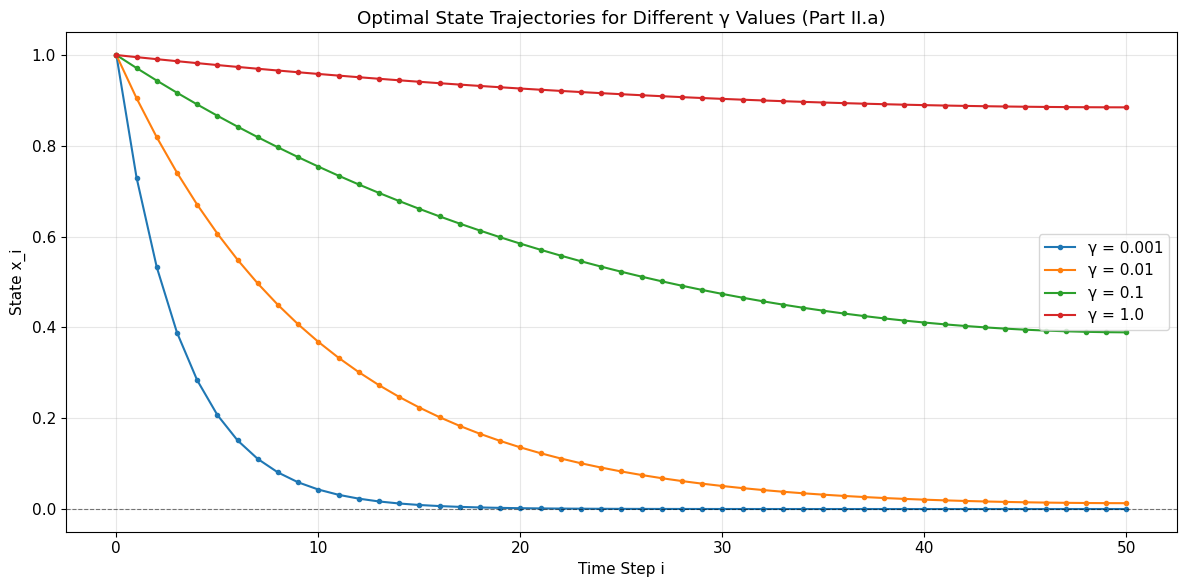


Analysis of γ effect:
γ =  0.001: ||u||_2 =  39.5188, ||x||_2 =   1.0676, x_N =   0.0000
γ =  0.010: ||u||_2 =  22.3365, ||x||_2 =   2.1266, x_N =   0.0129
γ =  0.100: ||u||_2 =  10.3638, ||x||_2 =   4.2301, x_N =   0.3891
γ =  1.000: ||u||_2 =   1.8804, ||x||_2 =   6.5245, x_N =   0.8848

Observation:
As γ increases, the control effort ||u||_2 decreases (more regularization),
while the state trajectory norm ||x||_2 increases (worse state tracking).
This demonstrates the trade-off between control energy and state regulation.


In [4]:
# Plot optimal controls
fig, ax = plt.subplots(figsize=(12, 6))

for gamma in gamma_values:
    u_star = results_IIa[gamma]['u']
    ax.plot(range(1, N+1), u_star, marker='o', markersize=3, label=f'γ = {gamma}')

ax.set_xlabel('Time Step i')
ax.set_ylabel('Control u_i')
ax.set_title('Optimal Control Signals for Different γ Values (Part II.a)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot optimal trajectories
fig, ax = plt.subplots(figsize=(12, 6))

for gamma in gamma_values:
    x_star = results_IIa[gamma]['x']
    ax.plot(range(N+1), x_star, marker='o', markersize=3, label=f'γ = {gamma}')

ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Time Step i')
ax.set_ylabel('State x_i')
ax.set_title('Optimal State Trajectories for Different γ Values (Part II.a)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print analysis
print("\nAnalysis of γ effect:")
print("=" * 60)
for gamma in gamma_values:
    u_norm = np.linalg.norm(results_IIa[gamma]['u'])
    x_norm = np.linalg.norm(results_IIa[gamma]['x'][1:])  # Exclude initial state
    final_state = results_IIa[gamma]['x'][-1]
    print(f"γ = {gamma:6.3f}: ||u||_2 = {u_norm:8.4f}, ||x||_2 = {x_norm:8.4f}, x_N = {final_state:8.4f}")

print("\nObservation:")
print("As γ increases, the control effort ||u||_2 decreases (more regularization),")
print("while the state trajectory norm ||x||_2 increases (worse state tracking).")
print("This demonstrates the trade-off between control energy and state regulation.")

## Part II.b): Multi-Objective Dynamic Optimisation

### Problem Formulation

With two systems:
- System 1: $x_0 = \bar{x}$, $x_i = ax_{i-1} + bu_i$
- System 2: $y_0 = \bar{y}$, $y_i = cy_{i-1} + dv_i$

The combined problem is:
$$\min_{(\mathbf{u},\mathbf{v}) \in \mathbb{R}^{2N}} \|\mathbf{x}\|_2^2 + \|\mathbf{y}\|_2^2 + \gamma\|\mathbf{u} - \mathbf{v}\|_2^2$$

This can be written as:
$$\min_{\mathbf{w} \in \mathbb{R}^{2N}} \left\|\begin{pmatrix} S_1 & 0 \\ 0 & S_2 \end{pmatrix} \begin{pmatrix} \mathbf{u} \\ \mathbf{v} \end{pmatrix} - \begin{pmatrix} \mathbf{b}_1 \\ \mathbf{b}_2 \end{pmatrix}\right\|_2^2 + \gamma\left\|\begin{pmatrix} I_N & -I_N \end{pmatrix} \begin{pmatrix} \mathbf{u} \\ \mathbf{v} \end{pmatrix}\right\|_2^2$$

where $\mathbf{w} = (\mathbf{u}^\top, \mathbf{v}^\top)^\top$.

In [5]:
def solve_multi_objective_problem(a, b, x_bar, c, d, y_bar, N, gamma):
    """
    Solve the multi-objective dynamic optimization problem.
    
    Parameters:
    -----------
    a, b : float
        System 1 parameters
    x_bar : float
        System 1 initial condition
    c, d : float
        System 2 parameters
    y_bar : float
        System 2 initial condition
    N : int
        Number of time steps
    gamma : float
        Regularization parameter
    
    Returns:
    --------
    u_star : ndarray of shape (N,)
        Optimal control for system 1
    v_star : ndarray of shape (N,)
        Optimal control for system 2
    x_star : ndarray of shape (N+1,)
        Optimal trajectory for system 1
    y_star : ndarray of shape (N+1,)
        Optimal trajectory for system 2
    """
    # Construct system matrices
    S1 = construct_system_matrix(a, b, N)
    b1 = construct_b_vector(a, x_bar, N)
    
    S2 = construct_system_matrix(c, d, N)
    b2 = construct_b_vector(c, y_bar, N)
    
    # Combined system matrix S
    S = np.block([
        [S1, np.zeros((N, N))],
        [np.zeros((N, N)), S2]
    ])
    
    # Combined right-hand side
    b_combined = np.concatenate([b1, b2])
    
    # Difference matrix D = [I_N, -I_N]
    D = np.hstack([np.eye(N), -np.eye(N)])
    
    # Solve: min ||Sw - b||^2 + gamma ||Dw||^2
    # Solution: w* = (S^T S + gamma D^T D)^{-1} S^T b
    A = S.T @ S + gamma * (D.T @ D)
    rhs = S.T @ b_combined
    w_star = solve(A, rhs)
    
    # Extract u and v
    u_star = w_star[:N]
    v_star = w_star[N:]
    
    # Compute trajectories
    x_star = compute_trajectory(a, b, x_bar, u_star)
    y_star = compute_trajectory(c, d, y_bar, v_star)
    
    return u_star, v_star, x_star, y_star

In [6]:
# Parameters for Part II.b)
N = 50
a = 1.0
b = 0.05
x_bar = 1.0
c = 0.2
d = -0.5
y_bar = 1.0
gamma = 1.0

# Solve the multi-objective problem
u_star, v_star, x_star, y_star = solve_multi_objective_problem(
    a, b, x_bar, c, d, y_bar, N, gamma
)

print(f"Part II.b) - Solved for γ = {gamma}")
print(f"||u||_2 = {np.linalg.norm(u_star):.6f}")
print(f"||v||_2 = {np.linalg.norm(v_star):.6f}")
print(f"||u - v||_2 = {np.linalg.norm(u_star - v_star):.6f}")
print(f"||x||_2 = {np.linalg.norm(x_star[1:]):.6f}")
print(f"||y||_2 = {np.linalg.norm(y_star[1:]):.6f}")

Part II.b) - Solved for γ = 1.0
||u||_2 = 4.328880
||v||_2 = 3.106410
||u - v||_2 = 1.222518
||x||_2 = 2.201535
||y||_2 = 2.000053


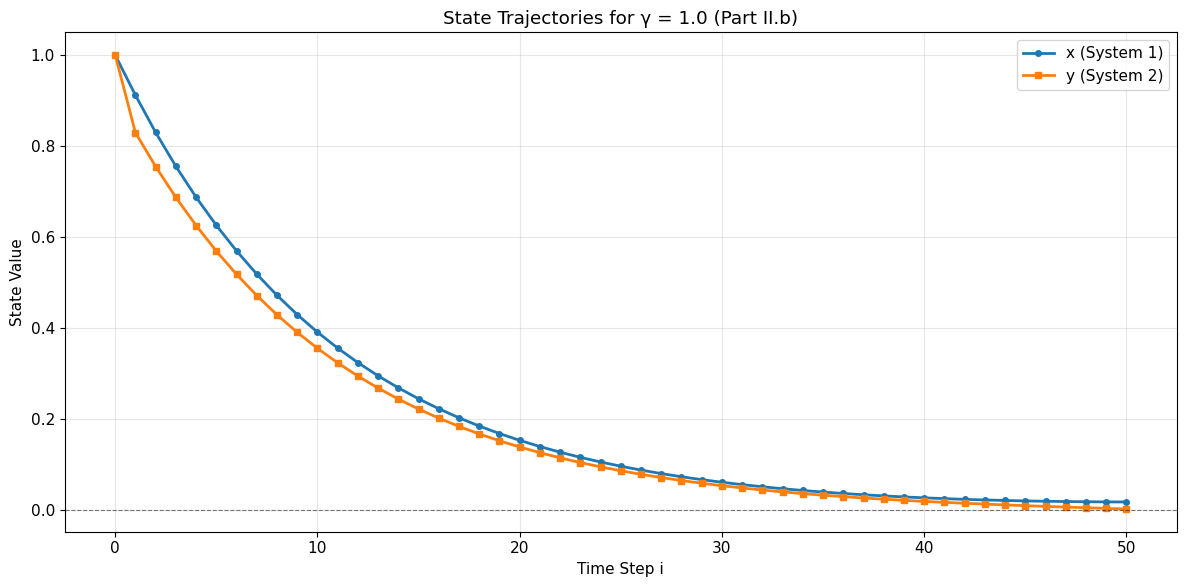

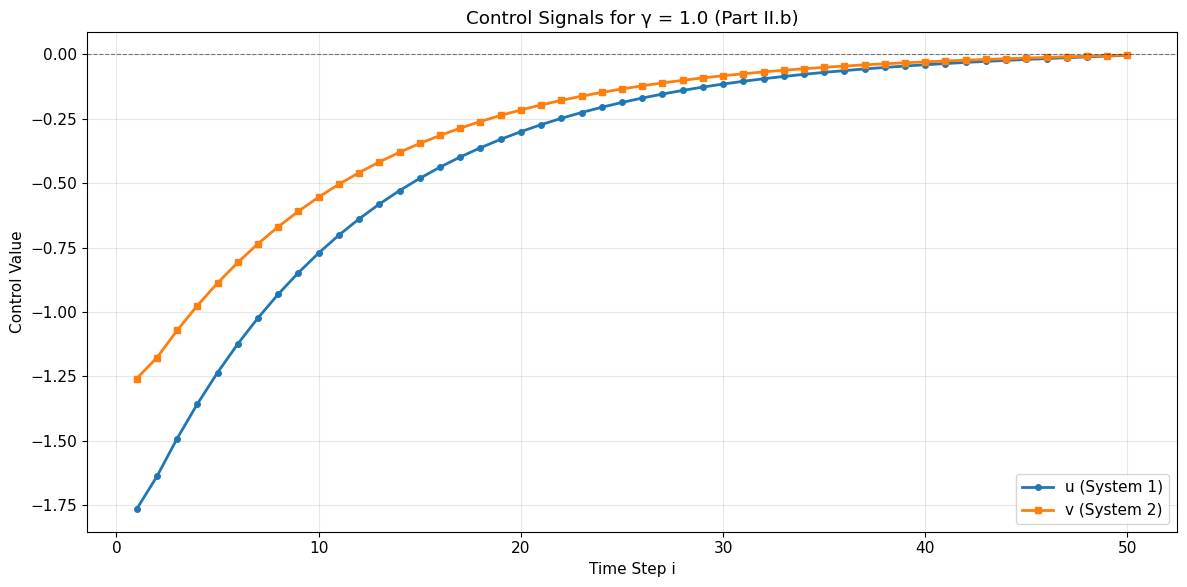

In [7]:
# Plot state trajectories
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(N+1), x_star, marker='o', markersize=4, label='x (System 1)', linewidth=2)
ax.plot(range(N+1), y_star, marker='s', markersize=4, label='y (System 2)', linewidth=2)
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)

ax.set_xlabel('Time Step i')
ax.set_ylabel('State Value')
ax.set_title(f'State Trajectories for γ = {gamma} (Part II.b)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot control signals
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(1, N+1), u_star, marker='o', markersize=4, label='u (System 1)', linewidth=2)
ax.plot(range(1, N+1), v_star, marker='s', markersize=4, label='v (System 2)', linewidth=2)
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)

ax.set_xlabel('Time Step i')
ax.set_ylabel('Control Value')
ax.set_title(f'Control Signals for γ = {gamma} (Part II.b)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part II.c): Pareto Front Analysis

### Multi-Objective Trade-offs

We analyze the functionals:
$$J_1(\gamma) = \|\mathbf{x}^*(\gamma)\|_2^2 + \|\mathbf{y}^*(\gamma)\|_2^2$$
$$J_2(\gamma) = \|\mathbf{u}^*(\gamma) - \mathbf{v}^*(\gamma)\|_2^2$$

The Pareto front $(J_1(\gamma), J_2(\gamma))$ characterizes the trade-off between:
- State regulation (minimizing $J_1$)
- Control similarity (minimizing $J_2$)

In [8]:
# Generate gamma values (logarithmically spaced)
gamma_log_range = np.arange(-5, 5.1, 0.1)
gamma_values_IIc = 10 ** gamma_log_range

# Initialize arrays to store J1 and J2
J1_values = np.zeros(len(gamma_values_IIc))
J2_values = np.zeros(len(gamma_values_IIc))

# Solve for each gamma value
print("Computing Pareto front...")
for idx, gamma in enumerate(gamma_values_IIc):
    u_star, v_star, x_star, y_star = solve_multi_objective_problem(
        a, b, x_bar, c, d, y_bar, N, gamma
    )
    
    J1_values[idx] = np.linalg.norm(x_star)**2 + np.linalg.norm(y_star)**2
    J2_values[idx] = np.linalg.norm(u_star - v_star)**2
    
    if idx % 20 == 0:
        print(f"  Progress: {idx}/{len(gamma_values_IIc)} ({100*idx/len(gamma_values_IIc):.1f}%)")

print("Done!")

Computing Pareto front...
  Progress: 0/101 (0.0%)
  Progress: 20/101 (19.8%)
  Progress: 40/101 (39.6%)
  Progress: 60/101 (59.4%)
  Progress: 80/101 (79.2%)
  Progress: 100/101 (99.0%)
Done!


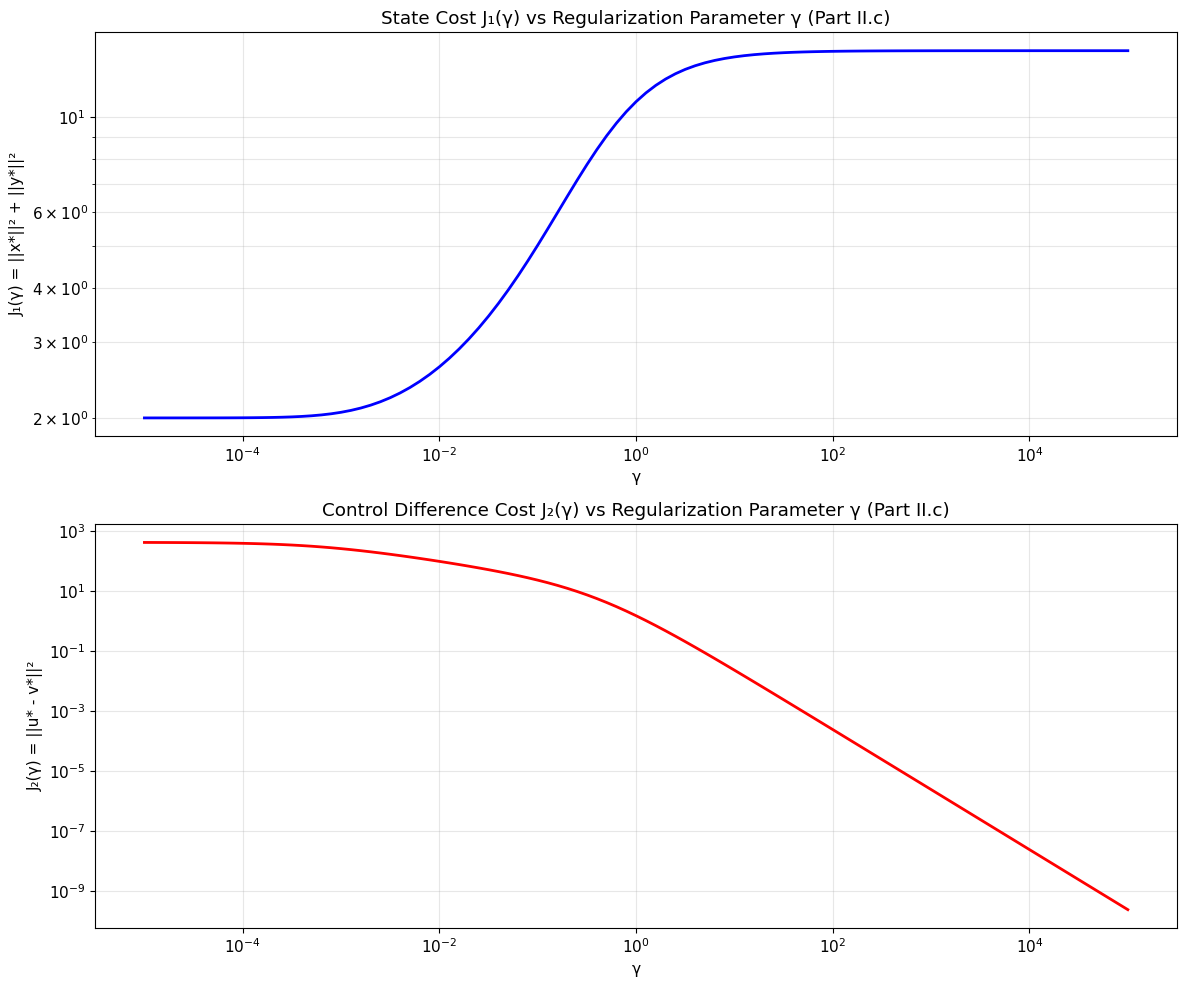

In [9]:
# Plot J1 and J2 versus gamma
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# J1 vs gamma
ax1.loglog(gamma_values_IIc, J1_values, 'b-', linewidth=2)
ax1.set_xlabel('γ')
ax1.set_ylabel('J₁(γ) = ||x*||² + ||y*||²')
ax1.set_title('State Cost J₁(γ) vs Regularization Parameter γ (Part II.c)')
ax1.grid(True, alpha=0.3, which='both')

# J2 vs gamma
ax2.loglog(gamma_values_IIc, J2_values, 'r-', linewidth=2)
ax2.set_xlabel('γ')
ax2.set_ylabel('J₂(γ) = ||u* - v*||²')
ax2.set_title('Control Difference Cost J₂(γ) vs Regularization Parameter γ (Part II.c)')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

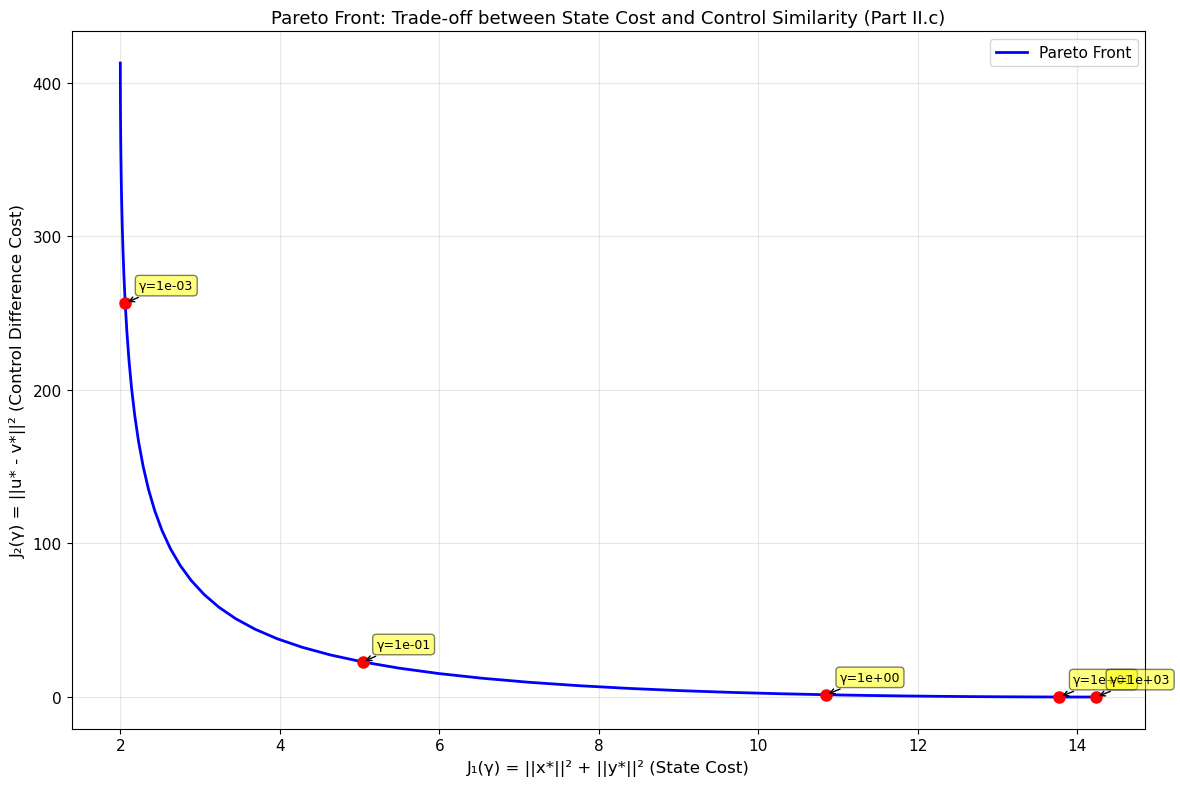

In [10]:
# Plot Pareto front: (J1, J2) curve
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the Pareto front
ax.plot(J1_values, J2_values, 'b-', linewidth=2, label='Pareto Front')

# Mark some specific gamma values
gamma_markers = [1e-3, 1e-1, 1.0, 10.0, 1e3]
for gamma_mark in gamma_markers:
    idx = np.argmin(np.abs(gamma_values_IIc - gamma_mark))
    ax.plot(J1_values[idx], J2_values[idx], 'ro', markersize=8)
    ax.annotate(f'γ={gamma_mark:.0e}', 
                xy=(J1_values[idx], J2_values[idx]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax.set_xlabel('J₁(γ) = ||x*||² + ||y*||² (State Cost)', fontsize=12)
ax.set_ylabel('J₂(γ) = ||u* - v*||² (Control Difference Cost)', fontsize=12)
ax.set_title('Pareto Front: Trade-off between State Cost and Control Similarity (Part II.c)', fontsize=13)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()


## Part II.d): L1 Regularization with Smooth Approximation

### Smooth L1 Approximation

The Huber-like function:
$$L_\epsilon(t) = \begin{cases}
\frac{1}{2}t^2 & \text{if } |t| \leq \epsilon \\
\epsilon\left(|t| - \frac{1}{2}\epsilon\right) & \text{if } |t| > \epsilon
\end{cases}$$

approximates $|t|$ with a smooth transition at $\pm\epsilon$. It is continuously differentiable with:
$$L_\epsilon'(t) = \begin{cases}
t & \text{if } |t| \leq \epsilon \\
\epsilon \cdot \text{sgn}(t) & \text{if } |t| > \epsilon
\end{cases}$$

### Gradient Descent

For the objective:
$$f(\mathbf{u}, \mathbf{v}) = \|S\mathbf{w} - \mathbf{b}\|_2^2 + \gamma_2\|D\mathbf{w}\|_2^2 + \gamma_1\sum_{i=1}^N L_\epsilon(u_i - v_i)$$

The gradient is:
$$\nabla f = 2(S^\top S + \gamma_2 D^\top D)\mathbf{w} - 2S^\top\mathbf{b} + \gamma_1 D^\top \mathbf{g}(D\mathbf{w})$$

where $\mathbf{g}(\mathbf{w})$ has components $g_i(w) = L_\epsilon'(w_i)$.

In [11]:
def L_epsilon(t, epsilon):
    """
    Smooth L1 approximation (Huber-like function).
    
    Parameters:
    -----------
    t : float or ndarray
        Input value(s)
    epsilon : float
        Smoothing parameter
    
    Returns:
    --------
    L : float or ndarray
        Function value(s)
    """
    abs_t = np.abs(t)
    return np.where(abs_t <= epsilon,
                    0.5 * t**2,
                    epsilon * (abs_t - 0.5 * epsilon))


def L_epsilon_derivative(t, epsilon):
    """
    Derivative of smooth L1 approximation.
    
    Parameters:
    -----------
    t : float or ndarray
        Input value(s)
    epsilon : float
        Smoothing parameter
    
    Returns:
    --------
    dL : float or ndarray
        Derivative value(s)
    """
    abs_t = np.abs(t)
    return np.where(abs_t <= epsilon,
                    t,
                    epsilon * np.sign(t))


def compute_lipschitz_constant(S, D, gamma1, gamma2, epsilon):
    """
    Compute the Lipschitz constant of the gradient.
    
    For the quadratic part, L is the spectral norm of 2(S^T S + gamma2 D^T D).
    For the L_epsilon part, the second derivative is bounded by 1 for |t| <= epsilon.
    
    Parameters:
    -----------
    S : ndarray of shape (2N, 2N)
        Combined system matrix
    D : ndarray of shape (N, 2N)
        Difference matrix
    gamma1 : float
        L1 regularization parameter
    gamma2 : float
        L2 regularization parameter
    epsilon : float
        Smoothing parameter
    
    Returns:
    --------
    L : float
        Lipschitz constant
    """
    # Hessian of the quadratic part
    H_quadratic = 2 * (S.T @ S + gamma2 * (D.T @ D))
    
    # For the L_epsilon term: second derivative is 1/epsilon for |t| <= epsilon
    # The contribution to the Hessian is gamma1 * D^T * diag(L''_epsilon(Dw)) * D
    # Upper bound: ||L''_epsilon|| <= 1 for |t| <= epsilon
    # So the Lipschitz constant contribution is at most gamma1 * ||D^T D||
    H_L1_bound = gamma1 * (D.T @ D)
    
    # Total Hessian upper bound
    H_upper = H_quadratic + H_L1_bound
    
    # Compute spectral norm (largest eigenvalue)
    eigenvalues = np.linalg.eigvalsh(H_upper)
    L = np.max(eigenvalues)
    
    return L


def compute_gradient(w, S, b_combined, D, gamma1, gamma2, epsilon):
    """
    Compute gradient of the objective function with L1 regularization.
    
    Parameters:
    -----------
    w : ndarray of shape (2N,)
        Current iterate [u; v]
    S : ndarray of shape (2N, 2N)
        Combined system matrix
    b_combined : ndarray of shape (2N,)
        Combined right-hand side
    D : ndarray of shape (N, 2N)
        Difference matrix [I_N, -I_N]
    gamma1 : float
        L1 regularization parameter
    gamma2 : float
        L2 regularization parameter
    epsilon : float
        Smoothing parameter for L1
    
    Returns:
    --------
    grad : ndarray of shape (2N,)
        Gradient vector
    """
    # Compute Dw = u - v
    Dw = D @ w
    
    # g(Dw) vector with L_epsilon derivative
    g_Dw = L_epsilon_derivative(Dw, epsilon)
    
    # Gradient: 2(S^T S + gamma2 D^T D)w - 2S^T b + gamma1 D^T g(Dw)
    grad = 2 * (S.T @ S + gamma2 * (D.T @ D)) @ w - 2 * S.T @ b_combined + gamma1 * (D.T @ g_Dw)
    
    return grad


def gradient_descent_L1(S, b_combined, D, gamma1, gamma2, epsilon, 
                        max_iter=10000, tol=1e-6):
    """
    Gradient descent for the L1-regularized problem with exact line search.
    Uses step size alpha = 1/(2L) where L is the Lipschitz constant.
    
    Parameters:
    -----------
    S : ndarray of shape (2N, 2N)
        Combined system matrix
    b_combined : ndarray of shape (2N,)
        Combined right-hand side
    D : ndarray of shape (N, 2N)
        Difference matrix
    gamma1 : float
        L1 regularization parameter
    gamma2 : float
        L2 regularization parameter
    epsilon : float
        Smoothing parameter
    max_iter : int
        Maximum number of iterations
    tol : float
        Tolerance for convergence (gradient norm)
    
    Returns:
    --------
    w : ndarray of shape (2N,)
        Optimal solution [u; v]
    history : dict
        Dictionary containing optimization history
    """
    N = D.shape[0]
    w = np.zeros(2 * N)  # Initialize at zero
    
    # Compute Lipschitz constant and step size
    L = compute_lipschitz_constant(S, D, gamma1, gamma2, epsilon)
    step_size = 0.5 / L
    
    print(f"Lipschitz constant L = {L:.6f}")
    print(f"Using step size α = 1/(2L) = {step_size:.6e}")
    
    history = {
        'grad_norm': [],
        'objective': []
    }
    
    for iteration in range(max_iter):
        # Compute gradient
        grad = compute_gradient(w, S, b_combined, D, gamma1, gamma2, epsilon)
        grad_norm = np.linalg.norm(grad)
        
        # Compute objective
        Sw_minus_b = S @ w - b_combined
        Dw = D @ w
        obj = np.linalg.norm(Sw_minus_b)**2 + gamma2 * np.linalg.norm(Dw)**2 + \
              gamma1 * np.sum(L_epsilon(Dw, epsilon))
        
        history['grad_norm'].append(grad_norm)
        history['objective'].append(obj)
        
        # Check convergence
        if grad_norm < tol:
            print(f"Converged at iteration {iteration} with ||∇f|| = {grad_norm:.2e}")
            break
        
        # Update with exact line search step size
        w = w - step_size * grad
        
        if iteration % 1000 == 0 and iteration > 0:
            print(f"Iteration {iteration}: ||∇f|| = {grad_norm:.2e}, f = {obj:.6f}")
    
    if iteration == max_iter - 1:
        print(f"Warning: Maximum iterations reached. ||∇f|| = {grad_norm:.2e}")
    
    return w, history


def solve_with_L1_regularization(a, b, x_bar, c, d, y_bar, N, 
                                  gamma1, gamma2, epsilon):
    """
    Solve the multi-objective problem with L1 regularization.
    
    Returns:
    --------
    u, v : ndarray
        Optimal controls
    x, y : ndarray
        Optimal trajectories
    history : dict
        Optimization history
    """
    # Construct matrices
    S1 = construct_system_matrix(a, b, N)
    b1 = construct_b_vector(a, x_bar, N)
    
    S2 = construct_system_matrix(c, d, N)
    b2 = construct_b_vector(c, y_bar, N)
    
    S = np.block([
        [S1, np.zeros((N, N))],
        [np.zeros((N, N)), S2]
    ])
    
    b_combined = np.concatenate([b1, b2])
    D = np.hstack([np.eye(N), -np.eye(N)])
    
    # Solve using gradient descent with exact line search
    w_star, history = gradient_descent_L1(S, b_combined, D, gamma1, gamma2, epsilon)
    
    # Extract solutions
    u_star = w_star[:N]
    v_star = w_star[N:]
    
    x_star = compute_trajectory(a, b, x_bar, u_star)
    y_star = compute_trajectory(c, d, y_bar, v_star)
    
    return u_star, v_star, x_star, y_star, history

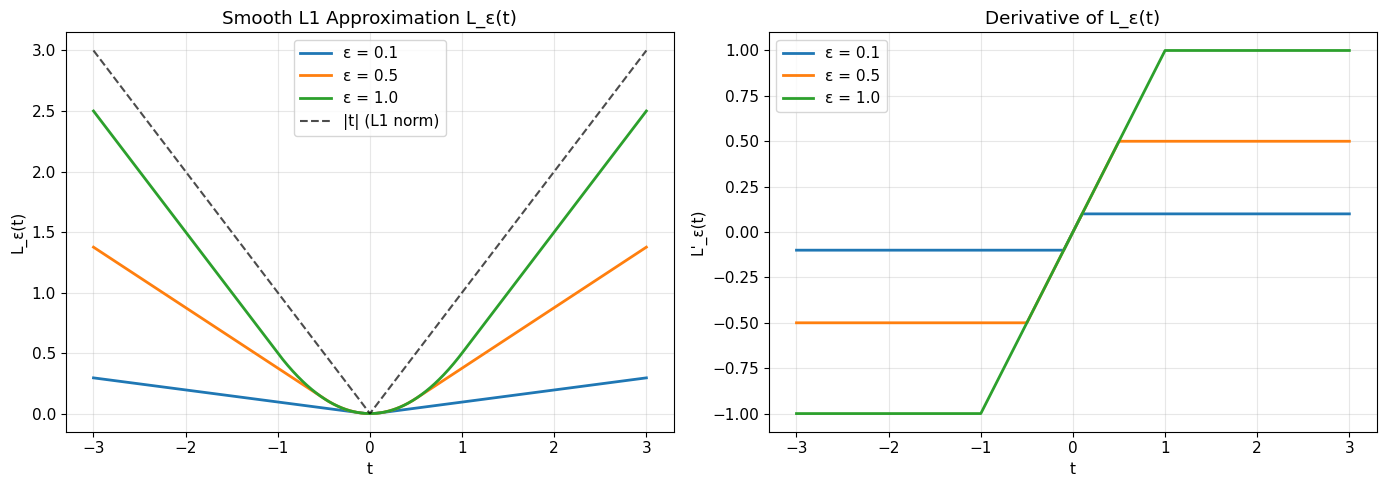


Explanation of L_ε as a regularizer:
L_ε(t) approximates the L1 norm |t|, which promotes sparsity.

• For |t| ≤ ε: Behaves like ½t² (quadratic), providing smooth gradient
• For |t| > ε: Behaves like ε(|t| - ½ε) ≈ ε|t| (linear)

The derivative L'_ε(t) is continuous everywhere, making it suitable for
gradient-based optimization. Smaller ε makes L_ε closer to |t| and
promotes stronger sparsity in the solution.

In our context, Σ L_ε(u_i - v_i) encourages many components of (u - v)
to be exactly zero, resulting in sparse differences between controls.


In [12]:
# Visualize L_epsilon function
t_vals = np.linspace(-3, 3, 1000)
epsilon_vals = [0.1, 0.5, 1.0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot L_epsilon
for eps in epsilon_vals:
    ax1.plot(t_vals, L_epsilon(t_vals, eps), linewidth=2, label=f'ε = {eps}')
ax1.plot(t_vals, np.abs(t_vals), 'k--', linewidth=1.5, label='|t| (L1 norm)', alpha=0.7)
ax1.set_xlabel('t')
ax1.set_ylabel('L_ε(t)')
ax1.set_title('Smooth L1 Approximation L_ε(t)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot derivative
for eps in epsilon_vals:
    ax2.plot(t_vals, L_epsilon_derivative(t_vals, eps), linewidth=2, label=f'ε = {eps}')
ax2.set_xlabel('t')
ax2.set_ylabel("L'_ε(t)")
ax2.set_title('Derivative of L_ε(t)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nExplanation of L_ε as a regularizer:")
print("=" * 70)
print("L_ε(t) approximates the L1 norm |t|, which promotes sparsity.")
print("")
print("• For |t| ≤ ε: Behaves like ½t² (quadratic), providing smooth gradient")
print("• For |t| > ε: Behaves like ε(|t| - ½ε) ≈ ε|t| (linear)")
print("")
print("The derivative L'_ε(t) is continuous everywhere, making it suitable for")
print("gradient-based optimization. Smaller ε makes L_ε closer to |t| and")
print("promotes stronger sparsity in the solution.")
print("")
print("In our context, Σ L_ε(u_i - v_i) encourages many components of (u - v)")
print("to be exactly zero, resulting in sparse differences between controls.")

In [13]:
# Solve for three cases as specified
print("\n" + "="*70)
print("Case (i): ε = 1, γ₂ = 1, γ₁ = 0 (same as Part II.b)")
print("="*70)
u1, v1, x1, y1, hist1 = solve_with_L1_regularization(
    a, b, x_bar, c, d, y_bar, N, 
    gamma1=0.0, gamma2=1.0, epsilon=1.0
)

print("\n" + "="*70)
print("Case (ii): ε = 1, γ₂ = 0, γ₁ = 1")
print("="*70)
u2, v2, x2, y2, hist2 = solve_with_L1_regularization(
    a, b, x_bar, c, d, y_bar, N, 
    gamma1=1.0, gamma2=0.0, epsilon=1.0
)

print("\n" + "="*70)
print("Case (iii): ε = 0.1, γ₂ = 0, γ₁ = 1")
print("="*70)
u3, v3, x3, y3, hist3 = solve_with_L1_regularization(
    a, b, x_bar, c, d, y_bar, N, 
    gamma1=1.0, gamma2=0.0, epsilon=0.1
)

# Store results
cases = [
    ('Case (i): L2 only (ε=1, γ₂=1, γ₁=0)', u1, v1, x1, y1, hist1),
    ('Case (ii): L1 only (ε=1, γ₂=0, γ₁=1)', u2, v2, x2, y2, hist2),
    ('Case (iii): L1 strong (ε=0.1, γ₂=0, γ₁=1)', u3, v3, x3, y3, hist3)
]


Case (i): ε = 1, γ₂ = 1, γ₁ = 0 (same as Part II.b)
Lipschitz constant L = 7.942352
Using step size α = 1/(2L) = 6.295365e-02
Converged at iteration 853 with ||∇f|| = 9.96e-07

Case (ii): ε = 1, γ₂ = 0, γ₁ = 1
Lipschitz constant L = 6.385201
Using step size α = 1/(2L) = 7.830608e-02
Converged at iteration 706 with ||∇f|| = 9.90e-07

Case (iii): ε = 0.1, γ₂ = 0, γ₁ = 1
Lipschitz constant L = 6.385201
Using step size α = 1/(2L) = 7.830608e-02
Iteration 1000: ||∇f|| = 6.08e-02, f = 2.187257
Iteration 2000: ||∇f|| = 3.41e-02, f = 2.042818
Iteration 3000: ||∇f|| = 1.97e-02, f = 1.994279
Iteration 4000: ||∇f|| = 1.63e-02, f = 1.968904
Iteration 5000: ||∇f|| = 1.35e-02, f = 1.951575
Iteration 6000: ||∇f|| = 1.11e-02, f = 1.939743
Iteration 7000: ||∇f|| = 9.21e-03, f = 1.931663
Iteration 8000: ||∇f|| = 7.61e-03, f = 1.926145
Iteration 9000: ||∇f|| = 1.78e-04, f = 1.925666


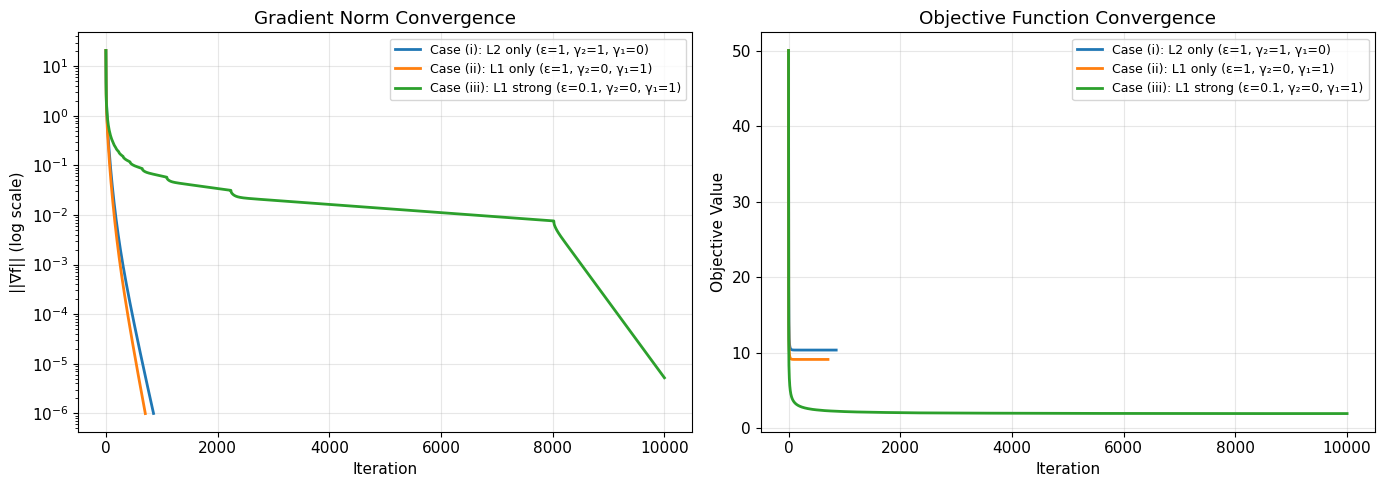

In [14]:
# Plot convergence history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for label, _, _, _, _, hist in cases:
    ax1.semilogy(hist['grad_norm'], linewidth=2, label=label)
    ax2.plot(hist['objective'], linewidth=2, label=label)

ax1.set_xlabel('Iteration')
ax1.set_ylabel('||∇f|| (log scale)')
ax1.set_title('Gradient Norm Convergence')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Objective Value')
ax2.set_title('Objective Function Convergence')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

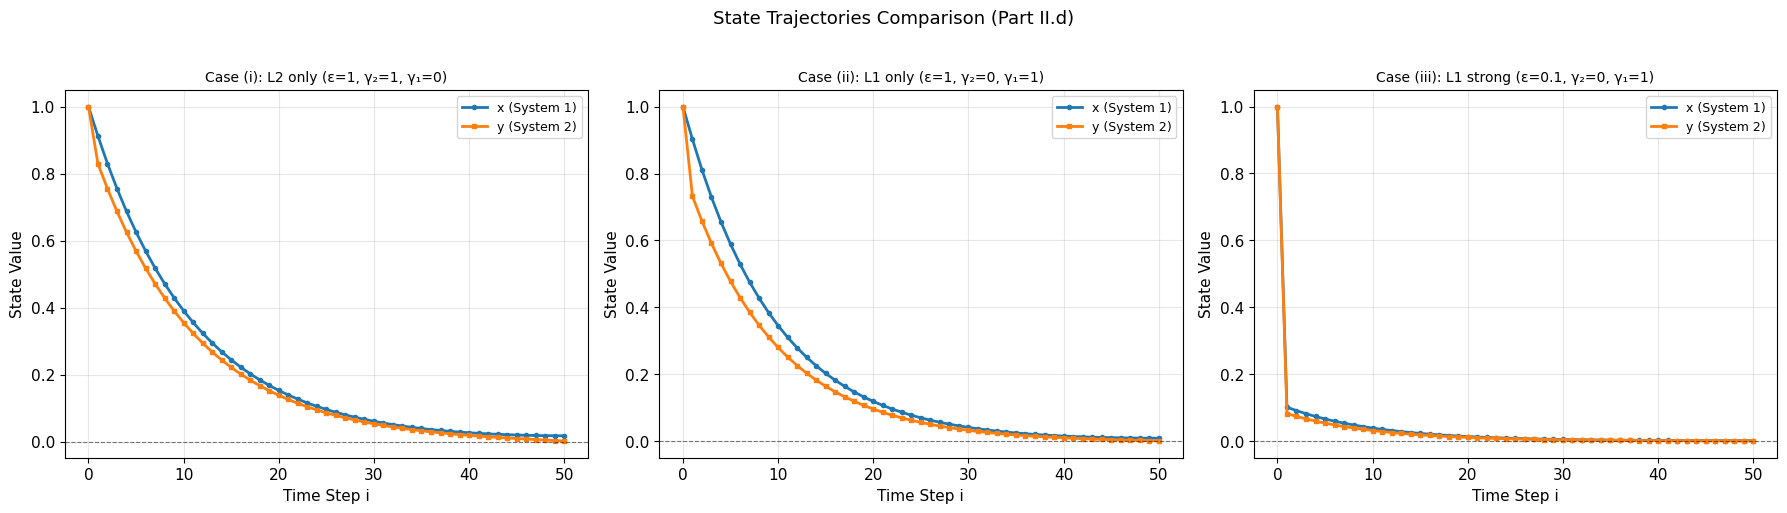

In [15]:
# Plot state trajectories comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (label, u, v, x, y, _) in enumerate(cases):
    ax = axes[idx]
    ax.plot(range(N+1), x, marker='o', markersize=3, label='x (System 1)', linewidth=2)
    ax.plot(range(N+1), y, marker='s', markersize=3, label='y (System 2)', linewidth=2)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_xlabel('Time Step i')
    ax.set_ylabel('State Value')
    ax.set_title(label, fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('State Trajectories Comparison (Part II.d)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

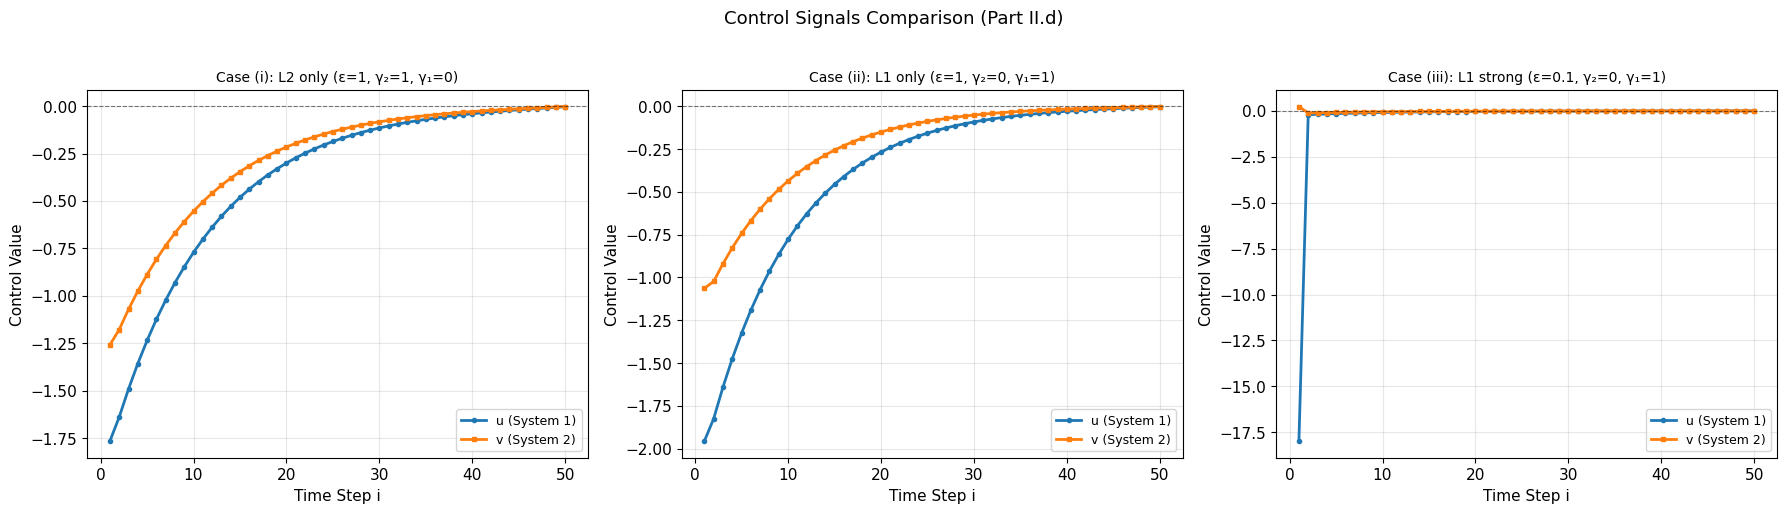

In [16]:
# Plot control signals comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (label, u, v, x, y, _) in enumerate(cases):
    ax = axes[idx]
    ax.plot(range(1, N+1), u, marker='o', markersize=3, label='u (System 1)', linewidth=2)
    ax.plot(range(1, N+1), v, marker='s', markersize=3, label='v (System 2)', linewidth=2)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_xlabel('Time Step i')
    ax.set_ylabel('Control Value')
    ax.set_title(label, fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Control Signals Comparison (Part II.d)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

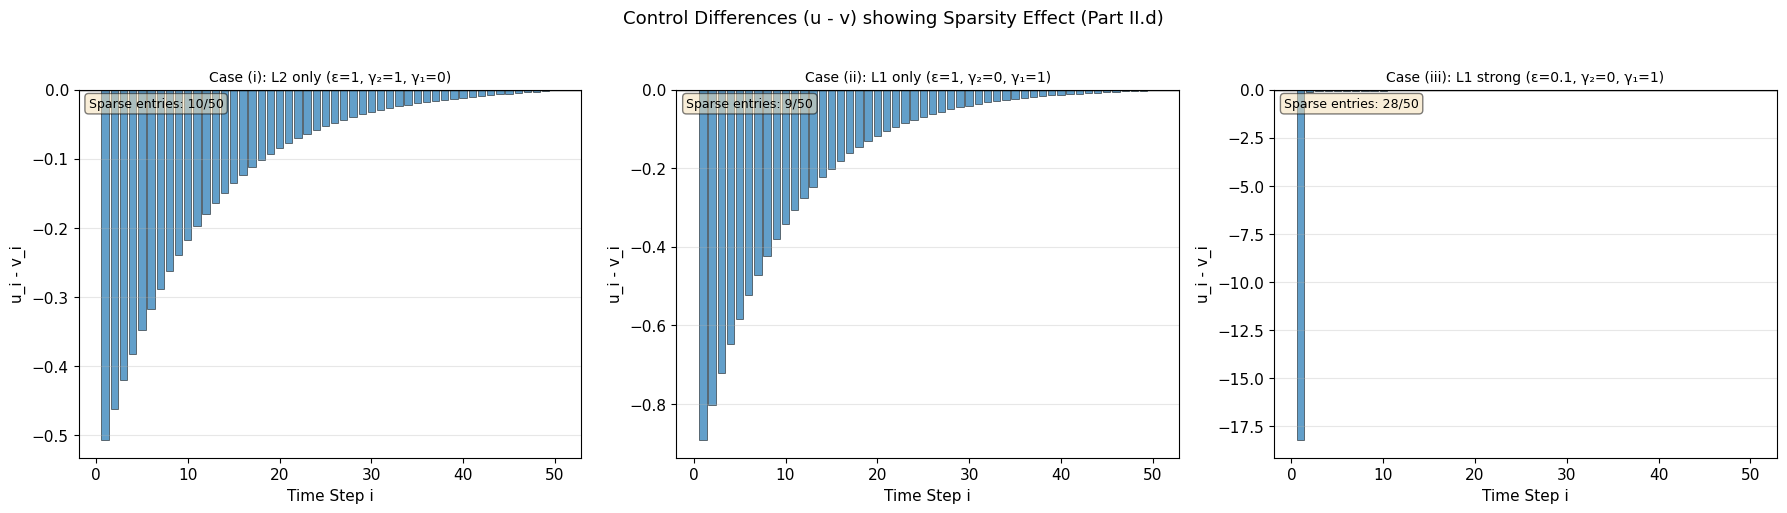

In [17]:
# Plot control differences to highlight sparsity
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (label, u, v, x, y, _) in enumerate(cases):
    ax = axes[idx]
    diff = u - v
    
    # Bar plot to show sparsity
    ax.bar(range(1, N+1), diff, width=0.8, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=1)
    ax.set_xlabel('Time Step i')
    ax.set_ylabel('u_i - v_i')
    ax.set_title(label, fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Count sparse entries (close to zero)
    sparse_count = np.sum(np.abs(diff) < 1e-2)
    ax.text(0.02, 0.98, f'Sparse entries: {sparse_count}/{N}',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=9)

plt.suptitle('Control Differences (u - v) showing Sparsity Effect (Part II.d)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [18]:
# Numerical comparison
print("\nNumerical Comparison of Three Cases:")
print("=" * 70)

for label, u, v, x, y, _ in cases:
    print(f"\n{label}")
    print("-" * 70)
    print(f"  ||x||_2 = {np.linalg.norm(x[1:]):.6f}")
    print(f"  ||y||_2 = {np.linalg.norm(y[1:]):.6f}")
    print(f"  ||u||_2 = {np.linalg.norm(u):.6f}")
    print(f"  ||v||_2 = {np.linalg.norm(v):.6f}")
    print(f"  ||u - v||_2 = {np.linalg.norm(u - v):.6f}")
    print(f"  ||u - v||_1 = {np.linalg.norm(u - v, 1):.6f}")
    
    # Count near-zero entries
    diff = u - v
    sparse_1e2 = np.sum(np.abs(diff) < 1e-2)
    sparse_1e3 = np.sum(np.abs(diff) < 1e-3)
    print(f"  Sparse entries (|u_i - v_i| < 1e-2): {sparse_1e2}/{N}")
    print(f"  Sparse entries (|u_i - v_i| < 1e-3): {sparse_1e3}/{N}")



Numerical Comparison of Three Cases:

Case (i): L2 only (ε=1, γ₂=1, γ₁=0)
----------------------------------------------------------------------
  ||x||_2 = 2.201535
  ||y||_2 = 2.000052
  ||u||_2 = 4.328880
  ||v||_2 = 3.106410
  ||u - v||_2 = 1.222518
  ||u - v||_1 = 5.542268
  Sparse entries (|u_i - v_i| < 1e-2): 10/50
  Sparse entries (|u_i - v_i| < 1e-3): 1/50

Case (ii): L1 only (ε=1, γ₂=0, γ₁=1)
----------------------------------------------------------------------
  ||x||_2 = 2.059340
  ||y||_2 = 1.669517
  ||u||_2 = 4.599371
  ||v||_2 = 2.564342
  ||u - v||_2 = 2.035415
  ||u - v||_1 = 8.741067
  Sparse entries (|u_i - v_i| < 1e-2): 9/50
  Sparse entries (|u_i - v_i| < 1e-3): 1/50

Case (iii): L1 strong (ε=0.1, γ₂=0, γ₁=1)
----------------------------------------------------------------------
  ||x||_2 = 0.230849
  ||y||_2 = 0.187149
  ||u||_2 = 17.983302
  ||v||_2 = 0.352275
  ||u - v||_2 = 18.214358
  ||u - v||_1 = 19.093058
  Sparse entries (|u_i - v_i| < 1e-2): 28/50
  Sp